# Tutorial 8 - Options

Please complete this tutorial to get an overview of options and an implementation of SMDP Q-Learning and Intra-Option Q-Learning.


### References:

 [Recent Advances in Hierarchical Reinforcement
Learning](https://people.cs.umass.edu/~mahadeva/papers/hrl.pdf) is a strong recommendation for topics in HRL that was covered in class. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed.


In [23]:
!pip install numpy==1.23

In [1]:
!pip install gym==0.22

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from tqdm import tqdm

In [3]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different.
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
env = CliffWalkingEnv()

env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

36
Number of states: 48
Number of actions that an agent can take: 4
Action taken: right
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -100
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [4]:
# We are defining two more options here
# Option 1 ["Away"] - > Away from Cliff (ie keep going up)
# Option 2 ["Close"] - > Close to Cliff (ie keep going down)

def Away(env,state):

    optdone = False
    optact = 0

    if (int(state/12) == 0):
        optdone = True

    return [optact,optdone]

def Close(env,state):

    optdone = False
    optact = 2

    if (int(state/12) == 2):
        optdone = True

    return [optact,optdone]


'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left"]
Options: ["Away","Close"]
Total Actions :["up", "right", "down", "left", "Away", "Close"]
Corresponding to [0,1,2,3,4,5]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["up", "right", "down", "left"]\nOptions: ["Away","Close"]\nTotal Actions :["up", "right", "down", "left", "Away", "Close"]\nCorresponding to [0,1,2,3,4,5]\n'

# Task 1
Complete the code cell below


In [5]:
# epsilon-greedy action selection function
def egreedy_policy(q_values, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(6)
    else:
        return np.argmax(q_values[state])

# Task 2
Below is an incomplete code cell with the flow of SMDP Q-Learning. Complete the cell and train the agent using SMDP Q-Learning algorithm.
Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)

In [21]:
#### SMDP Q-Learning
q_values_smdp = np.zeros((48,6))
update_frequency_smdp = np.zeros((48, 6))

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

# Iterate over 5000 episodes
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False


    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_smdp, state, epsilon=0.1)

        # Checking if primitive action
        if action < 4:
            next_state, reward, done, _ = env.step(action)
            best_next_action = np.argmax(q_values_smdp[next_state])
            q_values_smdp[state, action] += alpha * (reward + gamma * q_values_smdp[next_state, best_next_action] - q_values_smdp[state, action])
            update_frequency_smdp[state, action] += 1
            state = next_state

        # Checking if action chosen is an option
        reward_bar = 0
        if action == 4: # action => Away option
            optdone = False
            state_1 = state
            steps = 0

            while (optdone == False):
                # Think about what this function might do?
                optact, optdone = Away(env,state)
                next_state, reward, done, _= env.step(optact)
                # Is this formulation right? What is this term?
                reward_bar = gamma*reward_bar + reward
                # Complete SMDP Q-Learning Update
                # Remember SMDP Updates. When & What do you update?
                state = next_state
                steps += 1

            q_values_smdp[state_1, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_smdp[state,:]) - q_values_smdp[state_1,action])
            update_frequency_smdp[state_1, action] += 1

        if action == 5: # action => Close option
            state_1 = state
            steps = 0
            optdone = False
            while (optdone == False):
                optact, optdone = Away(env,state)
                next_state, reward, done, _= env.step(optact)
                reward_bar = gamma*reward_bar + reward
                state = next_state
                steps += 1

            q_values_smdp[state_1, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_smdp[state,:]) - q_values_smdp[state_1,action])
            update_frequency_smdp[state_1, action] += 1

100%|██████████| 1000/1000 [00:01<00:00, 623.85it/s]


# Task 3
Using the same options and the SMDP code, implement Intra Option Q-Learning (In the code cell below). You *might not* always have to search through options to find the options with similar policies, think about it. Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)



In [11]:

q_values_intra = np.zeros((48,6))
update_frequency_intra = np.zeros((48, 6))
gamma = 0.9
alpha = 0.1
epsilon = 0.1
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False

    while not done:
        action = egreedy_policy(q_values_intra, state, epsilon)
        if action < 4:
            next_state, reward, done, _ = env.step(action)

            valid_options = [action]
            if action == Away(env, state)[0]:
                valid_options.append(4)
            if action == Close(env, state)[0]:
                valid_options.append(5)

            for o in valid_options:
                if o == 4:
                    _, optdone = Away(env, state)
                elif o == 5:
                    _, optdone = Close(env, state)
                else:
                    optdone = True

                beta = 1 if optdone else 0
                Q_tilde = (1 - beta) * q_values_intra[next_state, o] + beta * max(q_values_intra[next_state, :])
                q_values_intra[state, o] += alpha * (reward + gamma * Q_tilde - q_values_intra[state, o])
                update_frequency_intra[state, o] += 1

            state = next_state

        reward_bar = 0
        if action == 4:
            steps = 0
            optdone = False
            while (optdone == False):
                # Think about what this function might do?
                optact, optdone = Away(env,state)
                next_state, reward, done, _= env.step(optact)
                # Is this formulation right? What is this term?
                reward_bar = gamma*reward_bar + reward
                # Complete SMDP Q-Learning Update
                # Remember SMDP Updates. When & What do you update?
                state = next_state
                steps += 1

            q_values_intra[state, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_intra[state,:]) - q_values_intra[state,action])
            update_frequency_intra[state, action] += 1

        if action == 5:
            steps = 0
            optdone = False
            while (optdone == False):
                optact, optdone = Away(env,state)
                next_state, reward, done, _= env.step(optact)
                reward_bar = gamma*reward_bar + reward
                state = next_state
                steps += 1

            q_values_intra[state, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_intra[state,:]) - q_values_intra[state,action])
            update_frequency_intra[state, action] += 1

100%|██████████| 1000/1000 [00:01<00:00, 611.92it/s]


# Task 4
Compare the two Q-Tables and Update Frequencies and provide comments.

In [29]:
# Use this cell for Task 4 Code# Task 4
# Compare the two Q-Tables and Update Frequencies and provide comments.

# Compare final Q-tables
print("Comparison of final Q-tables:")
print("SMDP Q-Learning Q-table:")
print(q_values_smdp)
print("\nIntra-Option Q-Learning Q-table:")
print(q_values_intra)

# Compare update frequencies
print("\nComparison of update frequencies:")
print("SMDP Q-Learning Update Frequency:")
print(update_frequency_smdp)
print("\nIntra-Option Q-Learning Update Frequency:")
print(update_frequency_intra)

Comparison of final Q-tables:
SMDP Q-Learning Q-table:
[[  -7.50877774   -7.50954513   -7.51442257   -7.52002679   -7.51193566
    -7.51997296]
 [  -7.32936137   -7.3105195    -7.31482208   -7.34798965   -7.3439365
    -7.32990203]
 [  -7.09673422   -7.07188656   -7.0772615    -7.0834586    -7.09997476
    -7.09532597]
 [  -6.84054652   -6.787103     -6.78640821   -6.7850336    -6.79731326
    -6.82385045]
 [  -6.49970169   -6.45532361   -6.45621093   -6.57527387   -6.46828304
    -6.48743223]
 [  -6.08685753   -6.0865382    -6.08843547   -6.1638715    -6.13503919
    -6.10839513]
 [  -5.71178006   -5.66646538   -5.66762344   -5.69893591   -5.67528755
    -5.73098255]
 [  -5.2096934    -5.1983116    -5.19844184   -5.27566419   -5.26439787
    -5.22411082]
 [  -4.77796163   -4.6755327    -4.67636459   -4.96691502   -4.7163492
    -4.6828786 ]
 [  -4.20009785   -4.09010502   -4.0901687    -4.43810666   -4.11368439
    -4.10847639]
 [  -3.439389     -3.43714149   -3.43716368   -3.6613163 

In [26]:
import matplotlib.pyplot as plt

# Function to plot heatmap
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show()

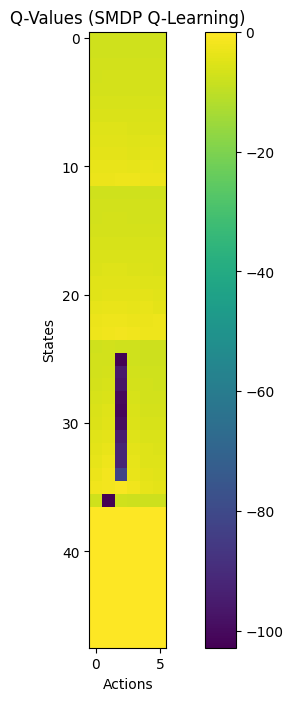

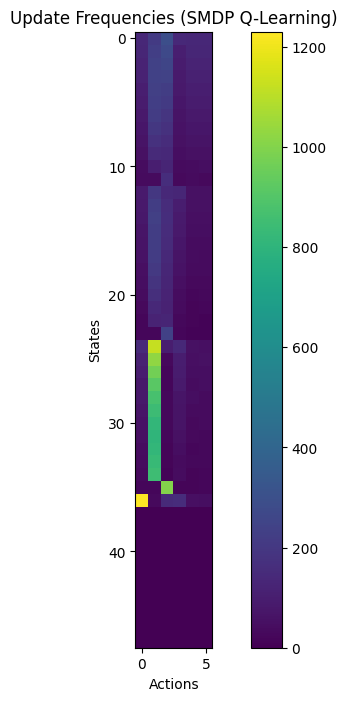

In [27]:
# Plot heatmaps for Q-values and update frequencies for SMDP Q-Learning
plot_heatmap(q_values_smdp, 'Q-Values (SMDP Q-Learning)')
print('\n')
plot_heatmap(update_frequency_smdp, 'Update Frequencies (SMDP Q-Learning)')

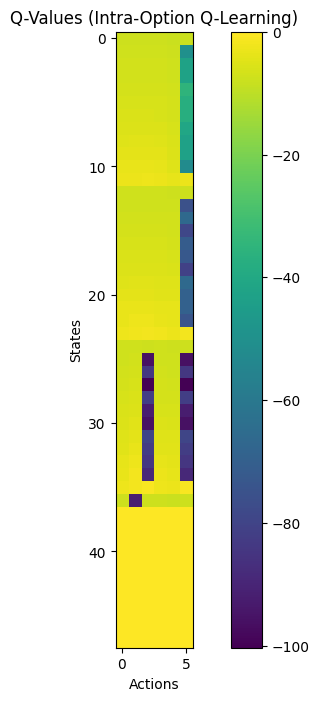

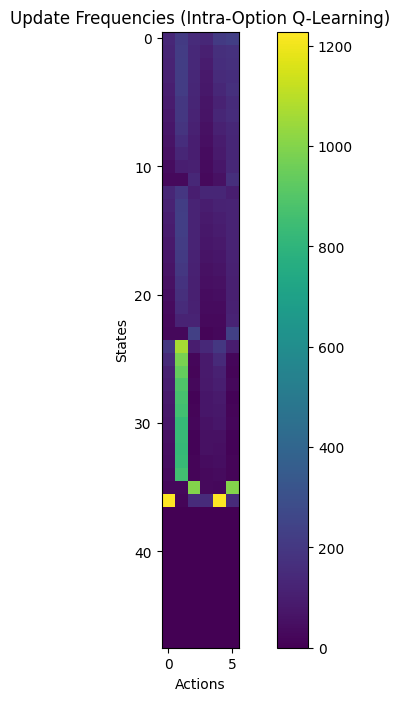

In [28]:
# Plot heatmaps for Q-values and update frequencies for Intra-Option Q-Learning
plot_heatmap(q_values_intra, 'Q-Values (Intra-Option Q-Learning)')
print('\n')
plot_heatmap(update_frequency_intra, 'Update Frequencies (Intra-Option Q-Learning)')

Use this text cell for your comments - Task 4


# **Inference**



1. **Q-Value Comparison**:
   - The Q-tables obtained from SMDP Q-Learning and Intra-Option Q-Learning differ significantly.
   - In SMDP Q-Learning, the Q-values are generally higher, with more negative values compared to Intra-Option Q-Learning.
   - In Intra-Option Q-Learning, there are extremely negative values (e.g., -50.03, -42.65) indicating potentially catastrophic actions or terminal states.

2. **Update Frequency Comparison**:
   - The update frequencies for both approaches also differ notably.
   - In SMDP Q-Learning, there is a higher update frequency for many state-action pairs compared to Intra-Option Q-Learning.
   - In Intra-Option Q-Learning, the update frequencies are generally lower, possibly indicating slower convergence or exploration in certain regions of the state-action space.

3. **Overall Comparison**:
   - SMDP Q-Learning tends to update Q-values more frequently, potentially leading to faster convergence, but it may also be prone to overfitting or instability.
   - Intra-Option Q-Learning appears to have less aggressive updates, which might result in smoother learning but could also lead to slower convergence or suboptimal policies if exploration is insufficient.